In [1]:
import os
import sys
import json
from pathlib import Path
sys.path.append(os.path.abspath('..'))

# ----------- local imports ----------- 
from utils import show_images, build_wandb_run
from sd_utils import get_prompt_embeddings, encode_vae, decode_vae, get_mask
from FashionDataset import FashionDataset, BottomCenterCrop
from constants import TRAIN_PATH

In [2]:
import torch
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from diffusers import UNet2DConditionModel, AutoencoderKL, PNDMScheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = torch.Generator(device=device).manual_seed(42)
dtype = torch.bfloat16

device

device(type='cuda')

In [3]:
positive_embeddings, negative_embeddings, combined_embeddings =  get_prompt_embeddings(device=device, dtype=dtype)

In [4]:
dataset = FashionDataset()

# Load HQ Image

In [5]:
src_path = TRAIN_PATH / "WOMEN_Skirts_id_00007488_02_1_front.png"
tar_path = TRAIN_PATH / "WOMEN_Skirts_id_00007488_02_7_additional.png"
src_img_ = Image.open(src_path)
tar_img_ = Image.open(tar_path)

In [6]:
# =================== Transforms ===================
original_image = (1101, 750)

image_resize = (1101, 750) # divided by 3 (H, W)
image_crop = (1096, 744) # H, W

img_transform = transforms.Compose([
    transforms.Resize(image_resize),
    BottomCenterCrop(image_crop),  # Custom bottom-center crop
])

to_tensor_transform = transforms.ToTensor()
normalize_transform = transforms.Normalize([0.5], [0.5])

In [7]:
# 1. resize + crop images
src_img = img_transform(src_img_)
tar_img = img_transform(tar_img_)

# 2. concate src with tar -> convert to tensor -> add batch dimension
init_img = to_tensor_transform( dataset.concatenate_src_tar(src_img, tar_img) ).unsqueeze(0).type(dtype).to(device)

# 3. generate mask
mask_img = torch.cat([
    torch.zeros((1, 1, 1096, 744)),
    torch.ones((1, 1, 1096, 744)),
], dim=3).type(dtype).to(device)

mask_latents = torch.cat([
    torch.zeros((1, 1, 1096//8, 744//8)),
    torch.ones((1, 1, 1096//8, 744//8)),
], dim=3).type(dtype).to(device)


# 4. normalize
init_img = normalize_transform(init_img)
masked_img = init_img * (1 - mask_img)

# Load Models

In [8]:
model_id = "SG161222/Realistic_Vision_V6.0_B1_noVAE"    
vae_link = "https://huggingface.co/stabilityai/sd-vae-ft-mse-original/vae-ft-mse-840000-ema-pruned.ckpt"
inpainting_link = "https://huggingface.co/SG161222/Realistic_Vision_V6.0_B1_noVAE/blob/main/Realistic_Vision_V6.0_NV_B1_inpainting_fp16.safetensors"


scheduler = PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")
vae = AutoencoderKL.from_single_file(vae_link, torch_dtype=dtype).to(device)

unet = UNet2DConditionModel.from_single_file(inpainting_link, 
                                            subfolder="unet",
                                            torch_dtype=dtype
                                        ).to(device)

# Inference Loop

  0%|          | 0/26 [00:00<?, ?it/s]

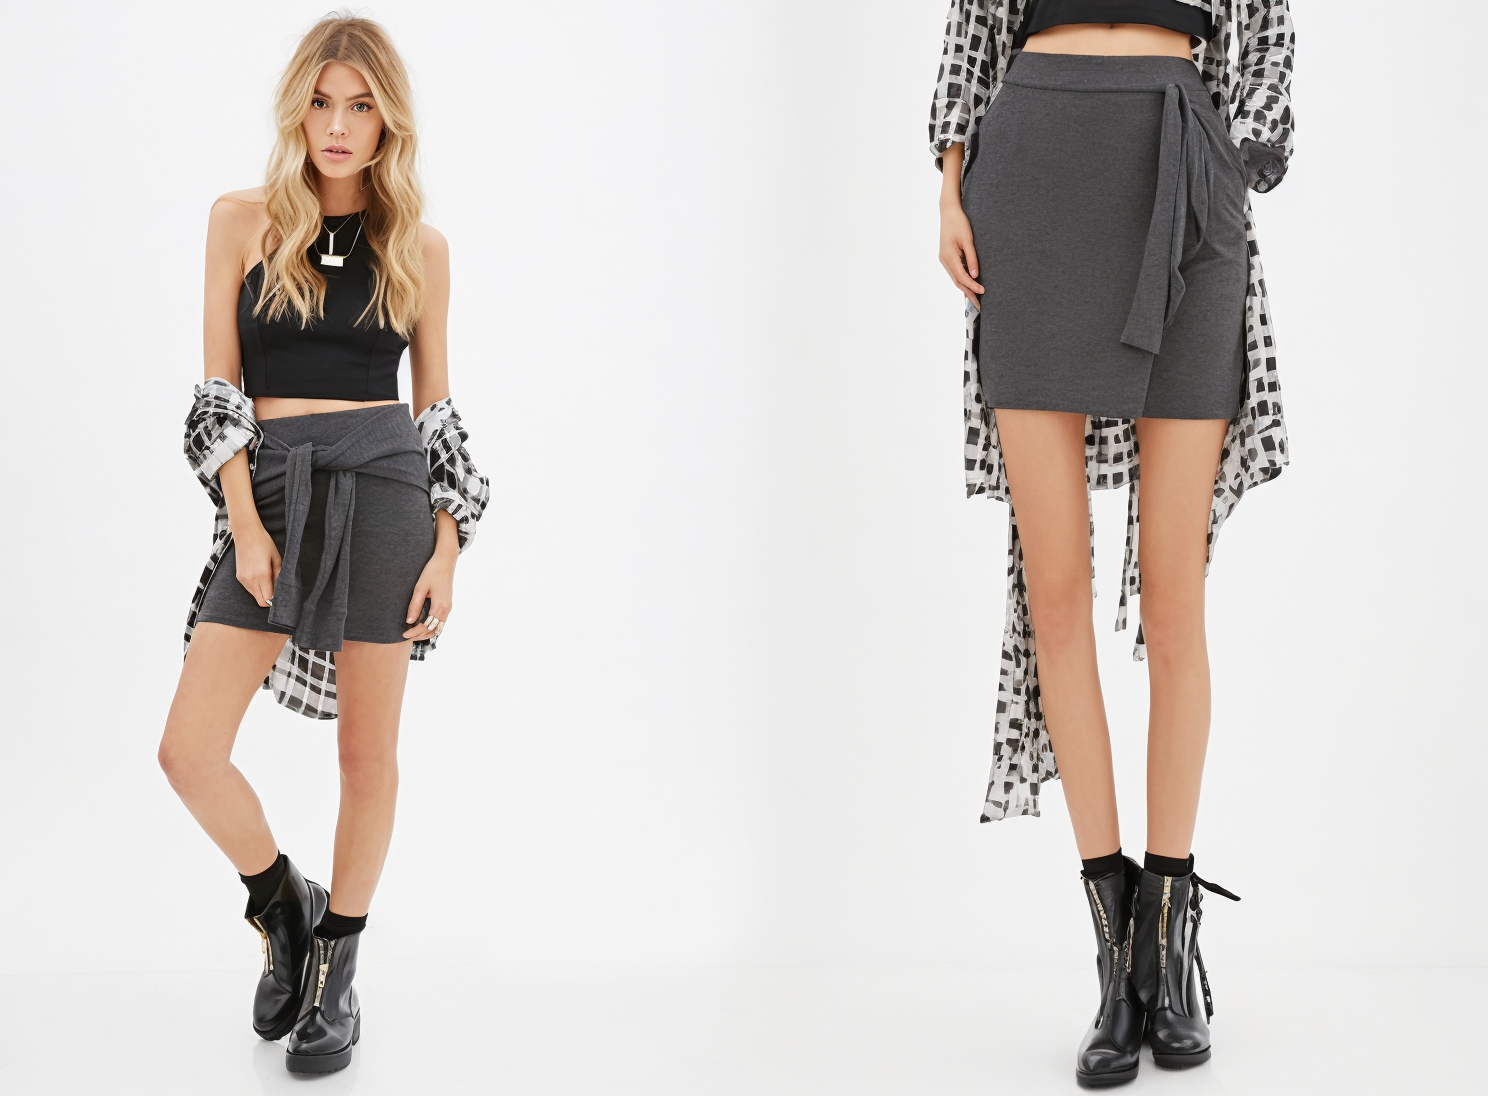

In [11]:
prompt_embeds = torch.cat([positive_embeddings,  negative_embeddings])

strength = 0.85 # @param
num_inference_steps = 30 # @param
guidance_scale = 2.0 # @param

# 1. setup timesteps for scheduler
scheduler.set_timesteps(num_inference_steps)
init_timestep = min(int(num_inference_steps * strength), num_inference_steps) # 42
t_start = max(num_inference_steps - init_timestep, 0) # 8
timesteps = scheduler.timesteps[t_start :]

# 2. generate latents
img_latents = encode_vae(init_img, vae)
noise = torch.randn_like(img_latents, device=device, dtype=dtype)
latents = scheduler.add_noise(img_latents, noise, timesteps[:1]) * scheduler.init_noise_sigma

masked_img_latents = encode_vae(masked_img, vae)


mask_ = torch.cat([mask_latents] * 2)
masked_img_latents_ = torch.cat([masked_img_latents] * 2)

for i, t in tqdm(enumerate(timesteps), total=len(timesteps)):
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)
    latent_model_input = torch.cat([latent_model_input, mask_, masked_img_latents_], dim=1)
    
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=prompt_embeds).sample
    # perform guidance
    noise_pos, noise_neg = noise_pred.chunk(2)
    noise_pred = noise_neg + guidance_scale * (noise_pos - noise_neg)
    latents = scheduler.step(noise_pred, t, latents).prev_sample
    
    
out = decode_vae(latents, vae)
show_images(out.type(torch.float32))